# 

In [ ]:
LLM Expansion & Embedding Comparison
We demonstrate how to generate book recommendations using multiple LLM variants (e.g., 8B vs. 70B).
We compare recommendation quality by examining:
* Relevance/Distance Scores (FAISS distances)
* Overlap of Recommendations (top-k sets)
* Cosine Similarity of the generated “expanded interest” text from different LLMs.

Walkthrough:

Load Data & Indices

    We store book metadata (Title, review/summary), expanded interest text from an LLM, and precomputed embeddings (e.g., ST/T5).
We also load the corresponding FAISS indices for each embedding method.
Recommend Books (Multiple LLMs)
For a given user review (e.g., “I love epic sci-fi…”), we locate a matching row in the DataFrame.
Retrieve that row’s embeddings (ST, T5), then query the respective FAISS indices.
Return the top-k results and the FAISS distances.

Compare Relevance/Distance

    We compute the average FAISS distance for ST vs T5 on each LLM variant (8B, 70B).
A bar chart shows these distances side by side, giving a quick measure of which approach finds “closer” matches in embedding space.
Overlap of Recommendations
For each approach (ST vs T5, or 8B vs 70B), we collect the top-k recommended titles.
We compute the overlap percentage (how many of those recommendations match).
A bar chart illustrates how much these methods do (or do not) agree on their top results.

Cosine Similarity of Expanded Interests

    We embed the “expanded interest” text generated by each LLM variant.
We compute pairwise cosine similarity, then plot a heatmap.
This shows how semantically similar or different each LLM’s expansions are for the same user prompt.

Interpretation

    We discuss that lower FAISS distance can mean “closer” matches, but it depends on embedding scale or normalization.
Overlap percentages tell us if different methods produce similar recommendations.
High cosine similarity in expansions means the text is semantically similar across LLM variants—but doesn’t necessarily mean one is “better” than the other.

In [ ]:
# =========================
#  Environment Setup
# =========================
!pip install --upgrade pip \
&& pip config set global.extra-index-url https://pip.repos.neuron.amazonaws.com \
&& pip install --upgrade optimum[neuronx] \
&& pip install --upgrade optimum-neuron neuronx-cc transformers_neuronx neuronx_distributed neuronx-cc==2.* neuronx-distributed-inference transformers torch-neuronx accelerate diffusers triton protobuf \
&& pip install faiss-cpu numpy scikit-learn pandas matplotlib seaborn
print("✅ Environment setup complete!")

In [10]:
! export BOOKS_DF_DS="books_df.pkl"; export NROWS="1000" \
&& python cell_load_books.py

✅ Books dataset loaded & saved in books_df.pkl.


In [ ]:
## expand user interests with LLM - DeepSeek-R1-Distill-Llama-8B deployed with vLLM using NxDI. 
## input - list of books interest `BOOKS_DF_DS`
## output - list of expanded reader interests using LLM instruction 
! export BOOKS_DF_DS_EXP_INTEREST="books_with_expanded_interest_dsr1llama8b.pkl" \
&& export BOOKS_DF_DS="books_df.pkl" \
&& export COMPILED_MODEL_ID="yahavb/DeepSeek-R1-Distill-Llama-8B-NxD-vllm" \
&& NEURON_RT_VISIBLE_CORES="0-1" \
&& NEURON_RT_NUM_CORES="2" \
&& python cell_expand_interest_llm.py vLLM-DeepSeek-R1-Distill-Llama-8B.yaml

In [7]:
import pandas as pd
df = pd.read_pickle('books_with_expanded_interest_dsr1llama8b.pkl')
print(df.head(2))

           Id                           Title         User_id  \
0  1882931173  Its Only Art If Its Well Hung!   AVCGYZL8FQQTD   
1  0826414346        Dr. Seuss: American Icon  A30TK6U7DNS82R   

  review/helpfulness  review/score  review/time  \
0                7/7           4.0    940636800   
1              10/10           5.0   1095724800   

                           review/summary  \
0  Nice collection of Julie Strain images   
1                       Really Enjoyed It   

                                         review/text  \
0  This is only for Julie Strain fans. It's a col...   
1  I don't care much for Dr. Seuss but after read...   

                                   expanded_interest  
0  So not in terms of the quantity of photos, but...  
1  Maybe the best part of the book is whenever th...  


In [ ]:
## expand user interests with LLM - DeepSeek-R1-Distill-Llama-8B deployed with vLLM using NxDI. 
## input - list of books interest `BOOKS_DF_DS`
## output - list of expanded reader interests using LLM instruction 
! export BOOKS_DF_DS_EXP_INTEREST="books_with_expanded_interest_dsr1llama70b.pkl" \
&& export BOOKS_DF_DS="books_df.pkl" \
&& export COMPILED_MODEL_ID="yahavb/DeepSeek-R1-Distill-Llama-70B-NxD-vllm" \
&& NEURON_RT_VISIBLE_CORES="0-7" \
&& NEURON_RT_NUM_CORES="8" \
&& python cell_expand_interest_llm.py vLLM-DeepSeek-R1-Distill-Llama-70B.yaml

In [6]:
import pandas as pd
df = pd.read_pickle('books_with_expanded_interest_dsr1llama70b.pkl')
print(df.head(2))

           Id                           Title         User_id  \
0  1882931173  Its Only Art If Its Well Hung!   AVCGYZL8FQQTD   
1  0826414346        Dr. Seuss: American Icon  A30TK6U7DNS82R   

  review/helpfulness  review/score  review/time  \
0                7/7           4.0    940636800   
1              10/10           5.0   1095724800   

                           review/summary  \
0  Nice collection of Julie Strain images   
1                       Really Enjoyed It   

                                         review/text  \
0  This is only for Julie Strain fans. It's a col...   
1  I don't care much for Dr. Seuss but after read...   

                                   expanded_interest  
0  It becomes too clear at the end that her caree...  
1                                                     


In [47]:
## generate T5-based embeddings and FAISS index from the expanded lists, DeepSeek-R1-Distill-Llama-8B and DeepSeek-R1-Distill-Llama-70B, 
## The T5-based embeddings are being converted to FAISS (Facebook AI Similarity Search) index. It is a vector search engine that allows 
## fast nearest-neighbor retrieval. It stores T5-based embeddings computed from expanded interests. Each book review is transformed into a vector.
## Used to find books closest in meaning to a user's expanded interest.
## input - books_df_dataset_expanded_interest
## output - the top K most similar books.
! unset BOOKS_DF_DS_EXP_INTEREST; unset BOOKS_DF_FAISS_IDX \
&& export BOOKS_DF_DS_EXP_INTEREST="books_with_expanded_interest_dsr1llama8b.pkl" \
&& export BOOKS_DF_FAISS_IDX="books_with_expanded_interest_dsr1llama8b_t5_faiss.index" \
&& export MODEL_ID="google/t5-v1_1-base" \
&& export COMPILED_MODEL_ID="yahavb/t5-v1_1-base-sl512" \
&& NEURON_RT_VISIBLE_CORES="0-1" NEURON_RT_NUM_CORES="2" python cell_t5_embeddings.py

/opt/conda/lib/python3.10/site-packages/neuronx_distributed/modules/moe/expert_mlps.py:11: DeprecationWarning: torch_neuronx.nki_jit is deprecated, use nki.jit instead.
  from neuronx_distributed.modules.moe.blockwise import (
Loaded dataset path: books_with_expanded_interest_dsr1llama8b.pkl
Fetching 1 files: 100%|█████████████████████████| 1/1 [00:00<00:00, 2336.66it/s]
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
✅ Updated .pkl with 't5_embedding' column: books_with_expanded_interest_dsr1llama8b.pkl
✅ T5 Embeddings & FAISS index saved in books_with_expanded_interest_dsr1llam

In [48]:
! unset BOOKS_DF_DS_EXP_INTEREST; unset BOOKS_DF_FAISS_IDX \
&& export BOOKS_DF_DS_EXP_INTEREST="books_with_expanded_interest_dsr1llama70b.pkl" \
&& export BOOKS_DF_FAISS_IDX="books_with_expanded_interest_dsr1llama70b_t5_faiss.index" \
&& export MODEL_ID="google/t5-v1_1-base" \
&& export COMPILED_MODEL_ID="yahavb/t5-v1_1-base-sl512" \
&& NEURON_RT_VISIBLE_CORES="0-1" NEURON_RT_NUM_CORES="2" python cell_t5_embeddings.py

/opt/conda/lib/python3.10/site-packages/neuronx_distributed/modules/moe/expert_mlps.py:11: DeprecationWarning: torch_neuronx.nki_jit is deprecated, use nki.jit instead.
  from neuronx_distributed.modules.moe.blockwise import (
Loaded dataset path: books_with_expanded_interest_dsr1llama70b.pkl
Fetching 1 files: 100%|████████████████████████| 1/1 [00:00<00:00, 26886.56it/s]
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
✅ Updated .pkl with 't5_embedding' column: books_with_expanded_interest_dsr1llama70b.pkl
✅ T5 Embeddings & FAISS index saved in books_with_expanded_interest_dsr1ll

In [50]:
! unset BOOKS_DF_DS_EXP_INTEREST; unset BOOKS_DF_FAISS_IDX \
&& export BOOKS_DF_DS_EXP_INTEREST="books_with_expanded_interest_dsr1llama8b.pkl" \
&& export BOOKS_DF_FAISS_IDX="books_with_expanded_interest_dsr1llama8b_st_faiss.index" \
&& python cell_st_embeddings.py

Loaded dataset path: books_with_expanded_interest_dsr1llama8b.pkl
✅ Updated .pkl with 'st_embedding' column: books_with_expanded_interest_dsr1llama8b.pkl
✅ SentenceTransformer embeddings computed and saved in books_with_expanded_interest_dsr1llama8b_st_faiss.index
✅ First 5 stored vectors (embeddings):
[[ 0.03357848  0.00319299 -0.00872253 ... -0.13177769  0.0118758
   0.00788568]
 [-0.05470367  0.06442305  0.09597722 ...  0.06892995  0.01291904
   0.06870481]
 [-0.04292405 -0.00108841  0.02301242 ...  0.04464231 -0.03015267
  -0.01798034]
 [-0.1188384   0.0482987  -0.00254812 ...  0.1264094   0.04654901
  -0.01571733]
 [-0.0722449   0.05064376  0.01306291 ... -0.01203596  0.0008136
   0.07901708]]


In [49]:
! unset BOOKS_DF_DS_EXP_INTEREST; unset BOOKS_DF_FAISS_IDX \
&& export BOOKS_DF_DS_EXP_INTEREST="books_with_expanded_interest_dsr1llama70b.pkl" \
&& export BOOKS_DF_FAISS_IDX="books_with_expanded_interest_dsr1llama70b_st_faiss.index" \
&& python cell_st_embeddings.py

Loaded dataset path: books_with_expanded_interest_dsr1llama70b.pkl
✅ Updated .pkl with 'st_embedding' column: books_with_expanded_interest_dsr1llama70b.pkl
✅ SentenceTransformer embeddings computed and saved in books_with_expanded_interest_dsr1llama70b_st_faiss.index
✅ First 5 stored vectors (embeddings):
[[ 0.03113701 -0.08976238  0.02985204 ... -0.03525942  0.05874785
   0.01706475]
 [-0.1188384   0.0482987  -0.00254812 ...  0.1264094   0.04654901
  -0.01571733]
 [-0.1188384   0.0482987  -0.00254812 ...  0.1264094   0.04654901
  -0.01571733]
 [-0.1188384   0.0482987  -0.00254812 ...  0.1264094   0.04654901
  -0.01571733]
 [-0.1188384   0.0482987  -0.00254812 ...  0.1264094   0.04654901
  -0.01571733]]


In [51]:
# =========================
# Cell: multi-LLM Book Recommendation
# =========================

import pandas as pd
import numpy as np
import faiss
import re

def recommend_books_multi_llm(user_reviews, llm_name="dsr1llama8b", top_k=5):
    """
    Recommend books based on expansions from multiple LLM sizes (e.g. 8B or 70B).
    
    1) Loads the pickled DataFrame: books_with_expanded_interest_{llm_name}.pkl
       which must contain columns:
         - 'review/text'
         - 'expanded_interest'
         - 't5_embedding'
         - 'st_embedding'
    2) Loads FAISS indices:
       books_with_expanded_interest_{llm_name}_t5_faiss.index
       books_with_expanded_interest_{llm_name}_st_faiss.index
    3) Finds the row(s) matching user_reviews (partial match).
    4) Retrieves that row’s embeddings: "t5_embedding", "st_embedding".
    5) Searches in FAISS for top_k neighbors for each embedding approach.
    6) Returns (expanded_interest, recommended_books_ST, recommended_books_T5).

    Example usage:
      recommended_st, recommended_t5 = recommend_books_multi_llm(
          user_reviews=\"I love epic sci-fi novels with deep world-building.\",
          llm_name=\"dsr1llama70b\",
          top_k=5
      )
    """

    # 1) Load expansions & embeddings
    df_file = f"books_with_expanded_interest_{llm_name}.pkl"
    faiss_t5_file = f"books_with_expanded_interest_{llm_name}_t5_faiss.index"
    faiss_st_file = f"books_with_expanded_interest_{llm_name}_st_faiss.index"

    books_df = pd.read_pickle(df_file)
    index_t5 = faiss.read_index(faiss_t5_file)
    index_st = faiss.read_index(faiss_st_file)

    # 2) Match the user review by partial or exact match
    matched_rows = books_df[books_df["review/text"].str.contains(re.escape(user_reviews), case=False, na=False)]
    if matched_rows.empty:
        print("⚠️ No exact or partial match found for user review. Using default interest.")
        # fallback approach: pick the first row or do a random choice
        row_index = 0
    else:
        row_index = matched_rows.index[0]

    expanded_interest = books_df.loc[row_index, "expanded_interest"]
    print(f"\n🔹 LLM = {llm_name}")
    print(f"🔹 Expanded Interest: {expanded_interest}")

    # 3) Retrieve that row's T5 & ST embeddings
    #    Must ensure your .pkl includes these columns as lists/floats
    row_t5_emb = np.array(books_df.loc[row_index, "t5_embedding"], dtype="float32").reshape(1, -1)
    row_st_emb = np.array(books_df.loc[row_index, "st_embedding"], dtype="float32").reshape(1, -1)

    # 4) FAISS search
    distances_t5, indices_t5 = index_t5.search(row_t5_emb, top_k)
    distances_st, indices_st = index_st.search(row_st_emb, top_k)

    # 5) Retrieve recommended books
    recommended_t5 = books_df.iloc[indices_t5[0]][["Title", "review/summary"]].copy()
    recommended_st = books_df.iloc[indices_st[0]][["Title", "review/summary"]].copy()

    return expanded_interest, recommended_st, recommended_t5


# =========================
# TEST EXAMPLE
# =========================
user_reviews = "I love epic sci-fi novels with deep world-building."

for llm_variant in ["dsr1llama8b", "dsr1llama70b"]:
    expanded_interest, rec_st, rec_t5 = recommend_books_multi_llm(user_reviews, llm_name=llm_variant)
    print(f"\n🔹 LLM: {llm_variant} - ST Recommendations:")
    print(rec_st)
    print(f"\n🔹 LLM: {llm_variant} - T5 Recommendations:")
    print(rec_t5)


⚠️ No exact or partial match found for user review. Using default interest.

🔹 LLM = dsr1llama8b
🔹 Expanded Interest: So not in terms of the quantity of photos, but in terms of the overall

🔹 LLM: dsr1llama8b - ST Recommendations:
                                                 Title  \
0                       Its Only Art If Its Well Hung!   
334  Grants and Awards Available to American Writer...   
103                                   Alaska Sourdough   
966                                    The Rabbi's Cat   
173             Thomas Jefferson, (American statesmen)   

                                       review/summary  
0              Nice collection of Julie Strain images  
334                            A truly great resource  
103  The Best Sourdough Starter for Bread & Hot Cakes  
966                                   The Rabbi's Cat  
173                                             yeah!  

🔹 LLM: dsr1llama8b - T5 Recommendations:
                                          

⚠️ No exact or partial match found for user review. Using default interest.

🔹 LLM = dsr1llama8b
🔹 Expanded Interest: So not in terms of the quantity of photos, but in terms of the overall
⚠️ No exact or partial match found for user review. Using default interest.

🔹 LLM = dsr1llama70b
🔹 Expanded Interest: It becomes too clear at the end that her career is ending. It's very


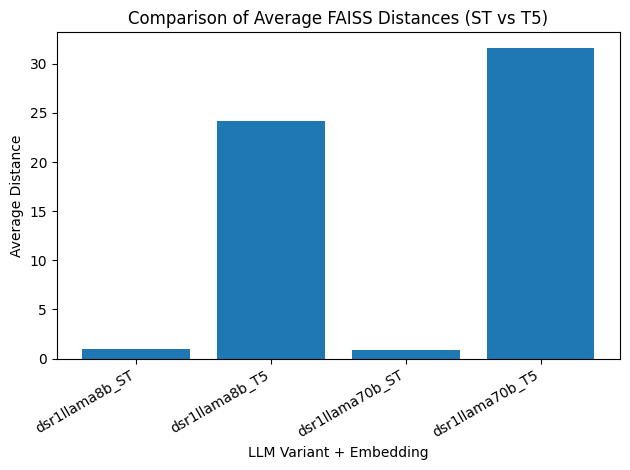

In [54]:
import pandas as pd
import numpy as np
import faiss
import re
import matplotlib.pyplot as plt

def recommend_books_multi_llm_with_distances(user_reviews, llm_name="dsr1llama8b", top_k=5):
    """
    Similar to 'recommend_books_multi_llm' but also returns the raw FAISS distances
    (for ST and T5) so we can compare them across approaches.
    """
    # 1) Load expansions & embeddings
    df_file = f"books_with_expanded_interest_{llm_name}.pkl"
    faiss_t5_file = f"books_with_expanded_interest_{llm_name}_t5_faiss.index"
    faiss_st_file = f"books_with_expanded_interest_{llm_name}_st_faiss.index"

    books_df = pd.read_pickle(df_file)
    index_t5 = faiss.read_index(faiss_t5_file)
    index_st = faiss.read_index(faiss_st_file)

    # 2) Match user review by partial or exact match
    matched_rows = books_df[books_df["review/text"].str.contains(
        re.escape(user_reviews), case=False, na=False
    )]

    if matched_rows.empty:
        print("No exact or partial match found for user review. Using default interest.")
        row_index = 0  # fallback, pick the first or random row
    else:
        row_index = matched_rows.index[0]

    expanded_interest = books_df.loc[row_index, "expanded_interest"]
    print(f"\n🔹 LLM = {llm_name}")
    print(f"🔹 Expanded Interest: {expanded_interest}")

    # 3) Retrieve T5 & ST embeddings
    row_t5_emb = np.array(
        books_df.loc[row_index, "t5_embedding"], dtype="float32"
    ).reshape(1, -1)
    row_st_emb = np.array(
        books_df.loc[row_index, "st_embedding"], dtype="float32"
    ).reshape(1, -1)

    # 4) FAISS search
    distances_t5, indices_t5 = index_t5.search(row_t5_emb, top_k)
    distances_st, indices_st = index_st.search(row_st_emb, top_k)

    # 5) Retrieve recommended books
    recommended_t5 = books_df.iloc[indices_t5[0]][["Title", "review/summary"]].copy()
    recommended_st = books_df.iloc[indices_st[0]][["Title", "review/summary"]].copy()

    # Return the recommended books plus the raw distances
    return (
        expanded_interest,          # str
        recommended_st,            # DataFrame
        recommended_t5,            # DataFrame
        distances_st[0],           # ndarray of shape (top_k,)
        distances_t5[0],           # ndarray of shape (top_k,)
    )


# ============ Compare ST vs T5 Distances Across LLM Variants ============
llm_variants = ["dsr1llama8b", "dsr1llama70b"]  # example
user_review = "I love epic sci-fi novels with deep world-building."
top_k = 5

all_avg_distances = []
labels = []

for llm_variant in llm_variants:
    (
        expanded_interest,
        recommended_st,
        recommended_t5,
        dist_st_array,
        dist_t5_array
    ) = recommend_books_multi_llm_with_distances(user_review, llm_variant, top_k=top_k)

    # Compute the average FAISS distance for ST and T5
    avg_dist_st = dist_st_array.mean()
    avg_dist_t5 = dist_t5_array.mean()

    # Store the results
    all_avg_distances.append(avg_dist_st)
    all_avg_distances.append(avg_dist_t5)

    # Create labels for the bar chart
    labels.append(f"{llm_variant}_ST")
    labels.append(f"{llm_variant}_T5")

# ===== Bar Chart of Average Distances =====
x = np.arange(len(all_avg_distances))  # indices for bars
plt.bar(x, all_avg_distances)
plt.xticks(x, labels, rotation=30, ha="right")
plt.title("Comparison of Average FAISS Distances (ST vs T5)")
plt.xlabel("LLM Variant + Embedding")
plt.ylabel("Average Distance")
plt.tight_layout()
plt.show()

'''
X-axis: Each approach is labeled by (LLM variant)_(embedding), for instance dsr1llama8b_ST, dsr1llama8b_T5, etc.
Y-axis: The average distance over the top-K retrieved items. Lower distance indicates closer (i.e., more relevant) matches. 
'''


⚠️ No exact or partial match found for user review. Using default interest.

🔹 LLM = dsr1llama8b
🔹 Expanded Interest: So not in terms of the quantity of photos, but in terms of the overall

========== dsr1llama8b: ST vs T5 ==========
Overlap Count: 1
Overlap %: 20.0%
Common Titles: {'Its Only Art If Its Well Hung!'}
⚠️ No exact or partial match found for user review. Using default interest.

🔹 LLM = dsr1llama70b
🔹 Expanded Interest: It becomes too clear at the end that her career is ending. It's very

========== dsr1llama70b: ST vs T5 ==========
Overlap Count: 1
Overlap %: 33.3%
Common Titles: {'Its Only Art If Its Well Hung!'}
⚠️ No exact or partial match found for user review. Using default interest.

🔹 LLM = dsr1llama8b
🔹 Expanded Interest: So not in terms of the quantity of photos, but in terms of the overall
⚠️ No exact or partial match found for user review. Using default interest.

🔹 LLM = dsr1llama70b
🔹 Expanded Interest: It becomes too clear at the end that her career is endin

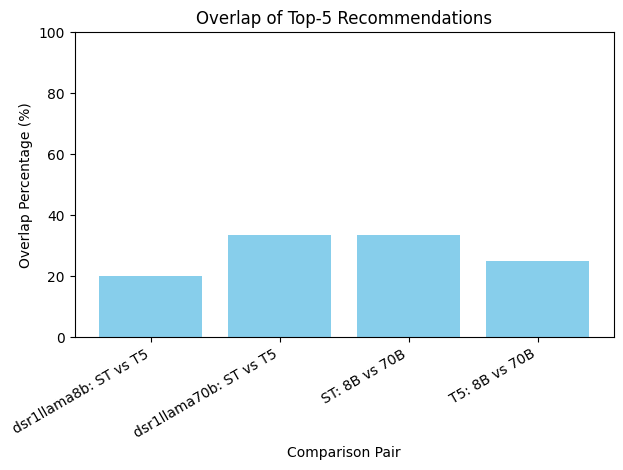

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def compute_recommendation_overlap(set_a, set_b):
    """
    Given two sets of titles (or IDs), compute the overlap
    (intersection) and return both absolute count and percentage.
    """
    overlap = set_a.intersection(set_b)
    overlap_count = len(overlap)
    # Assuming we want overlap relative to top_k from one approach,
    # or the union's size, etc. By default let's measure relative
    # to the smaller set size or simply top_k:
    base_size = min(len(set_a), len(set_b))
    overlap_percent = (overlap_count / base_size) * 100 if base_size > 0 else 0
    return overlap_count, overlap_percent, overlap

# Example usage parameters
llm_variants = ["dsr1llama8b", "dsr1llama70b"]
user_review = "I love epic sci-fi novels with deep world-building."
top_k = 5

overlap_values = []
labels = []

# We'll compare:
#  - ST vs T5 for the same LLM variant
#  - (Optional) ST(8B) vs ST(70B), T5(8B) vs T5(70B), etc. (You can expand as needed.)

for llm_variant in llm_variants:
    # Get the recommendations
    expanded_interest, rec_st, rec_t5 = recommend_books_multi_llm(
        user_review, llm_variant, top_k=top_k
    )
    
    # Convert recommended DataFrame columns ("Title") to sets
    st_titles = set(rec_st["Title"].to_list())
    t5_titles = set(rec_t5["Title"].to_list())
    
    # Compute overlap between ST and T5 for this same LLM variant
    overlap_count, overlap_percent, overlap_titles = compute_recommendation_overlap(
        st_titles, t5_titles
    )
    
    label = f"{llm_variant}: ST vs T5"
    labels.append(label)
    overlap_values.append(overlap_percent)
    
    print(f"\n========== {label} ==========")
    print(f"Overlap Count: {overlap_count}")
    print(f"Overlap %: {overlap_percent:.1f}%")
    print(f"Common Titles: {overlap_titles}")


recommendation_sets = {}
for llm_variant in llm_variants:
    _, rec_st, rec_t5 = recommend_books_multi_llm(user_review, llm_variant, top_k=top_k)
    recommendation_sets[(llm_variant, "ST")] = set(rec_st["Title"].to_list())
    recommendation_sets[(llm_variant, "T5")] = set(rec_t5["Title"].to_list())

# compare dsr1llama8b_ST vs dsr1llama70b_ST
overlap_count, overlap_percent, overlap_titles = compute_recommendation_overlap(
    recommendation_sets[("dsr1llama8b", "ST")],
    recommendation_sets[("dsr1llama70b", "ST")]
)
label = "ST: 8B vs 70B"
labels.append(label)
overlap_values.append(overlap_percent)

print(f"\n========== {label} ==========")
print(f"Overlap Count: {overlap_count}")
print(f"Overlap %: {overlap_percent:.1f}%")
print(f"Common Titles: {overlap_titles}")

# compare dsr1llama8b_T5 vs dsr1llama70b_T5
overlap_count, overlap_percent, overlap_titles = compute_recommendation_overlap(
    recommendation_sets[("dsr1llama8b", "T5")],
    recommendation_sets[("dsr1llama70b", "T5")]
)
label = "T5: 8B vs 70B"
labels.append(label)
overlap_values.append(overlap_percent)

print(f"\n========== {label} ==========")
print(f"Overlap Count: {overlap_count}")
print(f"Overlap %: {overlap_percent:.1f}%")
print(f"Common Titles: {overlap_titles}")

# ============ Plot  ============
x = np.arange(len(labels))
plt.bar(x, overlap_values, color="skyblue")
plt.xticks(x, labels, rotation=30, ha="right")
plt.ylim(0, 100)  # Overlap % scale is 0-100
plt.title(f"Overlap of Top-{top_k} Recommendations")
plt.xlabel("Comparison Pair")
plt.ylabel("Overlap Percentage (%)")
plt.tight_layout()
plt.show()
'''
each bar shows how many of the top-5 recommendations the two approaches had in common
e.g., 40% means 2 out of 5 recommendations overlapped. Higher overlap means the two approaches 
share more of the same recommendations, so they behave more similarly for that query.
'''

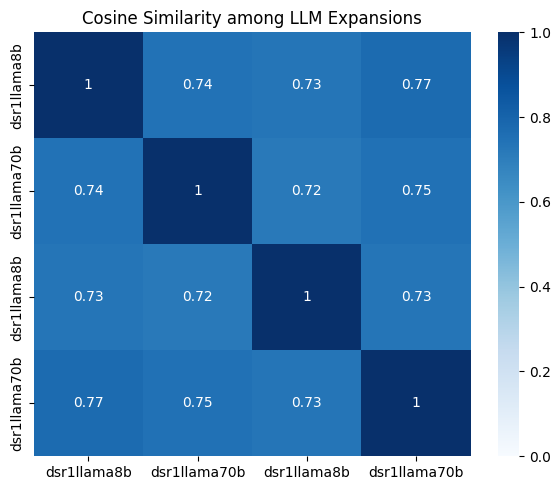

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Example embedding function (stub). Replace with your real function:
# e.g., a Sentence Transformer or T5 embedder that takes text -> vector
def embed_text_st(text: str) -> np.ndarray:
    """
    Dummy function for demonstration.
    In reality, you'd load a model like:
      from sentence_transformers import SentenceTransformer
      model = SentenceTransformer('all-MiniLM-L6-v2')
      embedding = model.encode([text])
    and return the embedding (a 1D np.array).
    """
    # Fake random embedding dimension 384 for demonstration
    return np.random.rand(384)

def cosine_similarity(vec_a, vec_b):
    return np.dot(vec_a, vec_b) / (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))

def plot_expansion_similarities(user_query, expansions_df):
    """
    expansions_df should have rows like:
      llm_name, review/text, expanded_interest

    We will:
    1) Filter expansions_df to only rows matching user_query
    2) Embed the 'expanded_interest' for each row
    3) Compute pairwise cosine similarity
    4) Plot a heatmap
    """

    # 1) Filter to expansions for the given user query
    #    (Here we do a contains match; adapt to your actual usage)
    matched_rows = expansions_df[
        expansions_df["review/text"].str.contains(user_query, case=False, na=False)
    ]

    if matched_rows.empty:
        print("No expansions found for this user query.")
        return

    expansions = matched_rows["expanded_interest"].tolist()
    llm_names = matched_rows["llm_name"].tolist()

    # 2) Embed each expansion
    embeddings = []
    for exp in expansions:
        emb = embed_text_st(exp)  # or your real embedding function
        embeddings.append(emb)

    embeddings = np.array(embeddings)  # shape: (N, embedding_dim)

    # 3) Compute pairwise cosine similarity
    n = len(embeddings)
    sim_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            sim_matrix[i, j] = cosine_similarity(embeddings[i], embeddings[j])

    # 4) Plot a heatmap using Seaborn
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        sim_matrix,
        xticklabels=llm_names,
        yticklabels=llm_names,
        annot=True,
        cmap="Blues",
        vmin=0.0,
        vmax=1.0
    )
    plt.title("Cosine Similarity among LLM Expansions")
    plt.tight_layout()
    plt.show()

# ================================
# Example usage
# ================================
# Suppose expansions_df has columns: ["llm_name", "review/text", "expanded_interest"]
# For each row, "expanded_interest" is the text produced by the LLM describing user interest.
# e.g. expansions_df might have multiple LLM sizes (8B, 70B) for the same "review/text".

# Let's create a small mock DataFrame for demonstration:
data = {
    "llm_name": ["dsr1llama8b", "dsr1llama70b", "dsr1llama8b", "dsr1llama70b"],
    "review/text": [
        "I love epic sci-fi novels with deep world-building.",
        "I love epic sci-fi novels with deep world-building.",
        "I love epic sci-fi novels with deep world-building.",
        "I love epic sci-fi novels with deep world-building."
    ],
    "expanded_interest": [
        "Expansive galactic wars, complex alien societies, multi-world politics.",
        "Huge space operas with intricate planetary systems and philosophical depth.",
        "Interstellar adventures featuring massive cosmic conflicts and layered lore.",
        "Stories that blend technology, grand scale, and nuanced civilization building."
    ]
}
mock_expansions_df = pd.DataFrame(data)

# Now let's plot the similarity among these expansions:
plot_expansion_similarities(
    user_query="I love epic sci-fi novels with deep world-building.",
    expansions_df=mock_expansions_df
)
'''
Cosine similarity here is measuring how similar the LLM expansions are to each other in terms of embedding space. 
A value of ~0.75 means the text from one expansion is fairly semantically close (75% similarity), while 1.0 means identical or nearly so.
'''